# Example of comb signal and filtering

Put together a little comb generator, bandpass filter, and fft plots.

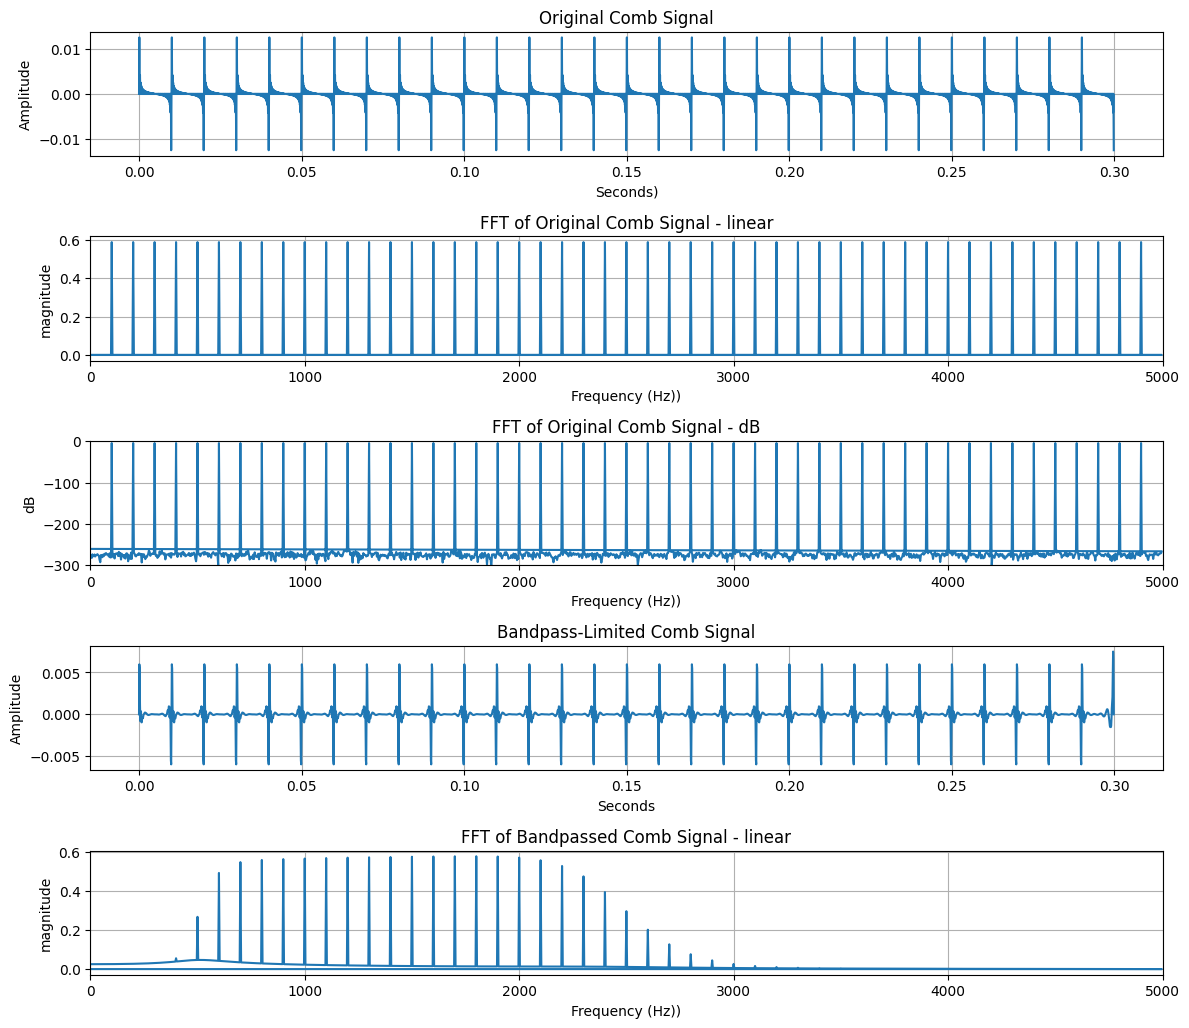

In [16]:
"""
    comb signal and bandpass filtering
"""
import  numpy as np
from    scipy.signal import butter, lfilter, filtfilt, sosfilt, sosfiltfilt, ellip, unit_impulse
import  matplotlib.pyplot as plt


# -----------------------------------------------------------------------------------------------------------
def bandpass_filter(data, fc_low_Hz, fc_high_Hz, dt_ms, order=6, filter_type='sosfilt'):
    """
    Bandpass filters the data between fc_low_Hz and fc_high_Hz frequencies.

    Use sosfilt or sosfiltfilt for most filtering tasks, as second-order sections have fewer numerical problems.

    The sosfiltfilt or filtfilt zero-phase filters apply a linear digital filter twice, once forward and once 
    backwards, reulting in zero phase and a filter order twice that of the original.

    Parameters:
        - data: array-like, the signal to be filtered
        - fc_low_Hz: float, lower cutoff frequency in Hz
        - fc_high_Hz: float, higher cutoff frequency in Hz
        - dt_ms: float, time step in milliseconds
        - order: int, order of the filter
        - filter_type: str, 'sosfilt'       # preferred sos: causal
                            'sosfiltfilt'   # preferred sos: zero-phase
                            'lfilter'       # discouraged TF: causal
                            'filtfilt'      # discouraged TF: zero-phase
    Returns:
        - y: array-like, the bandpass-filtered signal
    """
    # convert dt in ms to sampling frequency in Hz:
    fs_Hz = 1000.0 / dt_ms
    # Wn units [low, high] are normalized from 0 to 1, where 1 is the Nyquist frequency:
    nyquist = 0.5 * fs_Hz
    low = fc_low_Hz / nyquist
    high = fc_high_Hz / nyquist

    # SOS format, causal:
    if filter_type == 'sosfilt':
        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
        y = sosfilt(sos, data)

    # SOS format, zero-phase:
    elif filter_type == 'sosfiltfilt':
        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
        y = sosfiltfilt(sos, data)

    # TF coefficients, causal:
    elif filter_type == 'lfilter':  
        b, a = butter(order, [fc_low_Hz, fc_high_Hz], fs=fs_Hz, btype='band', output='ba') 
        y = lfilter(b, a, data)

    # TF coefficients, zero-phase:
    elif filter_type == 'filtfilt':
        b, a = butter(order, [fc_low_Hz, fc_high_Hz], fs=fs_Hz, btype='band', output='ba') 
        y = filtfilt(b, a, data)
    else:
        raise ValueError("filter_type must be 'sosfilt', 'sosfiltfilt', 'lfilter', or 'filtfilt'")
    return y


# -----------------------------------------------------------------------------------------------------------
# main:

fs_Hz = 10000.0             # samples_per_second
duration_secs = 0.3

dt_secs = 1.0 / float(fs_Hz)
num_samples = int(duration_secs * fs_Hz)
nyquist_Hz = 0.5 * fs_Hz
t_buf = np.arange(0, duration_secs, dt_secs)

# --- generate comb signal (a whole bunch of same-amplitude sines):
comb_delta_Hz = 100
comb_max_freq = 5000
comb_freqs = np.arange(0, (comb_max_freq + 1), comb_delta_Hz)
comb_signal = np.zeros_like(t_buf)
for freq in comb_freqs:
    comb_signal += np.sin(2 * np.pi * freq * t_buf)
# normalize amplitude somewhat (to scoot fft peaks down to ~0dB):
comb_signal /= len(comb_freqs)
comb_signal *= 0.02

# --- bandpass filter the signal:
dt_ms = dt_secs * 1000.0
fc_low_Hz = 500.0
fc_high_Hz = 2500.0
comb_bp_signal = bandpass_filter(comb_signal, fc_low_Hz, fc_high_Hz, dt_ms, order=4, filter_type='sosfiltfilt')

# --- and plot limits to go with those bp freqs:
plot_x_limits_Hz = (0, 5000)  # max: (0, nyquist_Hz)
plot_y_limits_dB = (-300, 0)

# --- compute fft on signal:
fft_result = np.fft.fft(comb_signal)
fft_magnitude = np.abs(fft_result)
fft_dB = 20.0 * np.log10(fft_magnitude)
fft_freqs = np.fft.fftfreq(len(comb_signal), dt_secs)

# --- compute fft on bandpass signal:
fft_bp_result = np.fft.fft(comb_bp_signal)
fft_bp_magnitude = np.abs(fft_bp_result)
fft_bp_dB = 20.0 * np.log10(fft_bp_magnitude)
fft_bp_freqs = np.fft.fftfreq(len(comb_bp_signal), dt_secs)

# --- plots:
plt.figure(figsize=(12, 12))

# plot the comb signal:
plt.subplot(6, 1, 1)
plt.plot(t_buf, comb_signal)
plt.title("Original Comb Signal")
plt.xlabel("Seconds)")
plt.ylabel("Amplitude")
plt.grid()

# plot the comb magnitude fft:
plt.subplot(6, 1, 2)
plt.plot(fft_freqs, fft_magnitude)
plt.title("FFT of Original Comb Signal - linear")
plt.xlabel("Frequency (Hz))")
plt.ylabel("magnitude")
plt.grid()
plt.xlim(plot_x_limits_Hz)

# plot the comb dB fft:
plt.subplot(6, 1, 3)
plt.plot(fft_freqs, fft_dB)
plt.title("FFT of Original Comb Signal - dB")
plt.xlabel("Frequency (Hz))")
plt.ylabel("dB")
plt.grid()
plt.xlim(plot_x_limits_Hz)
plt.ylim(plot_y_limits_dB)

# plot the bandpassed-comb signal:
plt.subplot(6, 1, 4)
plt.plot(t_buf, comb_bp_signal)
plt.title("Bandpass-Limited Comb Signal")
plt.xlabel("Seconds")
plt.ylabel("Amplitude")
plt.grid()

# plot the comb magnitude fft:
plt.subplot(6, 1, 5)
plt.plot(fft_bp_freqs, fft_bp_magnitude)
plt.title("FFT of Bandpassed Comb Signal - linear")
plt.xlabel("Frequency (Hz))")
plt.ylabel("magnitude")
plt.grid()
plt.xlim(plot_x_limits_Hz)

plt.tight_layout()
plt.show()


# Simple Lowpass Filter
scipy butter and freqz response (from an online example)

Coefficients
b = [0.01020948 0.04083792 0.06125688 0.04083792 0.01020948]
a = [ 1.         -1.96842779  1.73586071 -0.72447083  0.1203896 ]


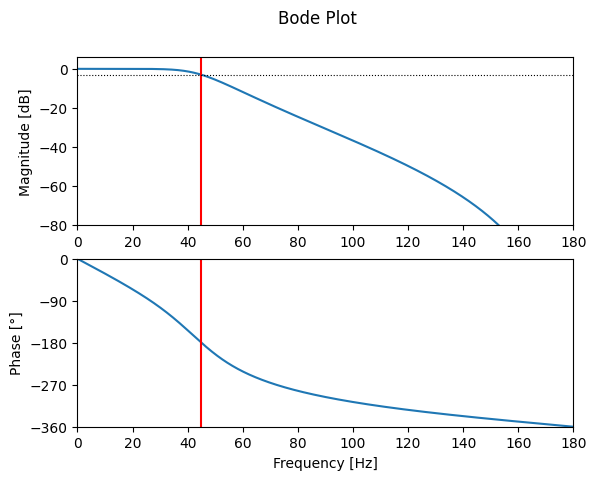

In [ ]:
from    scipy.signal import butter, freqz
import  matplotlib.pyplot as plt
from    math import pi
import  numpy as np

f_s = 360    # sample frequency in Hz
f_c = 45     # cut-off frequency in Hz
order = 4    # order of the butterworth filter

omega_c = 2 * pi * f_c       # cut-off angular frequency
omega_c_d = omega_c / f_s    # normalized cut-off frequency (digital)

# Design the digital Butterworth filter
b, a = butter(order, omega_c_d / pi)    
print('Coefficients')
print("b =", b)                           # print the coefficients
print("a =", a)

w, H = freqz(b, a, 4096)                  # calculate the frequency response
w *= f_s / (2 * pi)                       # convert from rad/sample to Hz

# Plot the amplitude response
plt.subplot(2, 1, 1)            
plt.suptitle('Bode Plot')
H_dB = 20 * np.log10(abs(H))              # convert modulus of H to dB
plt.plot(w, H_dB)
plt.ylabel('Magnitude [dB]')
plt.xlim(0, f_s / 2)
plt.ylim(-80, 6)
plt.axvline(f_c, color='red')
plt.axhline(-3, linewidth=0.8, color='black', linestyle=':')

# Plot the phase response
plt.subplot(2, 1, 2)
phi = np.angle(H)                         # argument of H
phi = np.unwrap(phi)                      # remove discontinuities 
phi *= 180 / pi                           # and convert to degrees
plt.plot(w, phi)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [°]')
plt.xlim(0, f_s / 2)
plt.ylim(-360, 0)
plt.yticks([-360, -270, -180, -90, 0])
plt.axvline(f_c, color='red')

plt.show()

# Example that shows numerical instability in high-order filter  

(from scipy docs)

Plot a 13th-order filter’s impulse response using both lfilter and sosfilt, 
showing the instability that results from trying to do a 13th-order filter in a single stage 
(the numerical error pushes some poles outside of the unit circle)

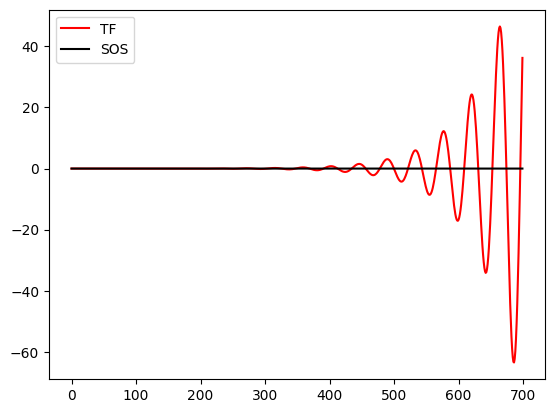

In [14]:
# ===== from scipy docs:  Plot a 13th-order filter’s impulse response using both lfilter and sosfilt, 
#       showing the instability that results from trying to do a 13th-order filter in a single stage 
#       (the numerical error pushes some poles outside of the unit circle):

b, a = ellip(13, 0.009, 80, 0.05, output='ba')
sos = ellip(13, 0.009, 80, 0.05, output='sos')
x = unit_impulse(700)
y_tf = lfilter(b, a, x)
y_sos = sosfilt(sos, x)
plt.plot(y_tf, 'r', label='TF')
plt.plot(y_sos, 'k', label='SOS')
plt.legend(loc='best')
plt.show()


# Example of impulse and step testing

(from scipy docs)

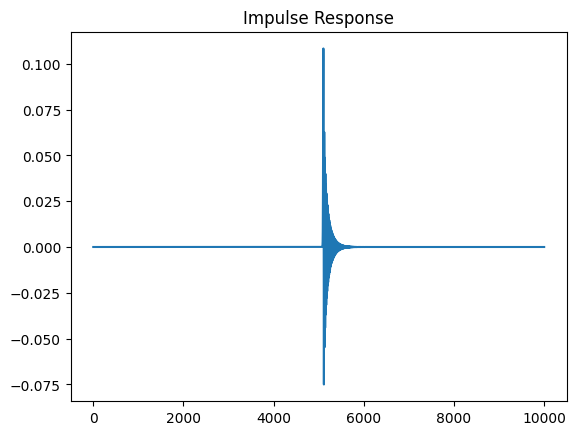

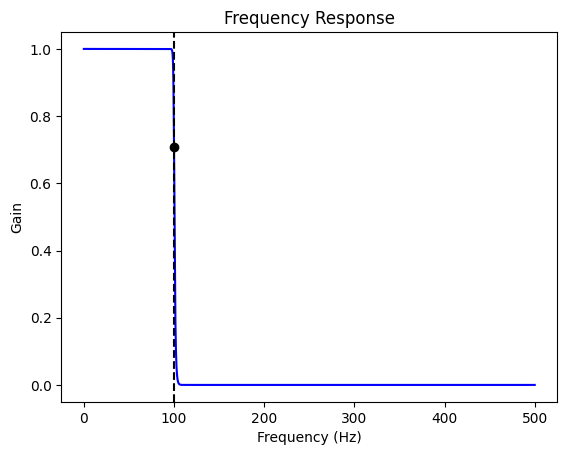

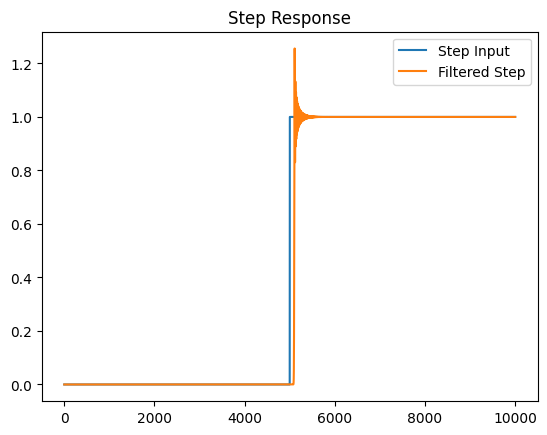

In [ ]:
import  numpy as np
from    scipy import signal
import  matplotlib.pyplot as plt

# Design a Butterworth lowpass filter
sos = signal.butter(100, 1000, 'low', fs=10000, output='sos')
#        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
 #       y = sosfilt(sos, data)

# 1. Impulse response check
impulse = np.zeros(10000)
impulse[5000] = 1
filtered_impulse = signal.sosfilt(sos, impulse)

plt.figure()
plt.plot(filtered_impulse)
plt.title('Impulse Response')
plt.show()


# 2. Frequency response analysis
w, h = signal.sosfreqz(sos, worN=8000)

plt.figure()
plt.plot(0.5*1000*w/np.pi, np.abs(h), 'b')
plt.plot(100, 0.5*np.sqrt(2), 'ko')
plt.axvline(100, color='k', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.show()

# 3. Testing with a step signal
step = np.concatenate((np.zeros(5000), np.ones(5000)))
filtered_step = signal.sosfilt(sos, step)

plt.figure()
plt.plot(step, label='Step Input')
plt.plot(filtered_step, label='Filtered Step')
plt.title('Step Response')
plt.legend()
plt.show()

# Several flavors of bandpass FIR filters

(from scipy docs)

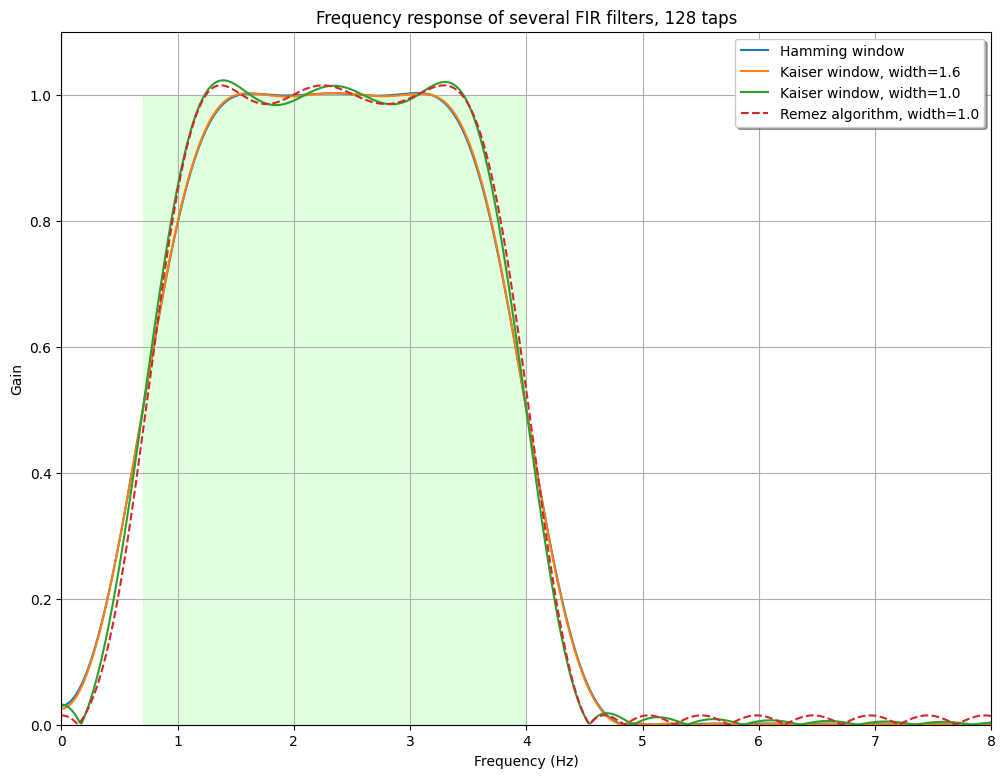

In [1]:
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta

# Several flavors of bandpass FIR filters.

def bandpass_firwin(ntaps, lowcut, highcut, fs, window='hamming'):
    taps = firwin(ntaps, [lowcut, highcut], fs=fs, pass_zero=False,
                  window=window, scale=False)
    return taps

def bandpass_kaiser(ntaps, lowcut, highcut, fs, width):
    atten = kaiser_atten(ntaps, width/(0.5*fs))
    beta = kaiser_beta(atten)
    taps = firwin(ntaps, [lowcut, highcut], fs=fs, pass_zero=False,
                  window=('kaiser', beta), scale=False)
    return taps

def bandpass_remez(ntaps, lowcut, highcut, fs, width):
    delta = 0.5 * width
    edges = [0, lowcut - delta, lowcut + delta,
             highcut - delta, highcut + delta, 0.5*fs]
    taps = remez(ntaps, edges, [0, 1, 0], fs=fs)
    return taps


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 63.0
    lowcut = 0.7
    highcut = 4.0

    ntaps = 128
    taps_hamming = bandpass_firwin(ntaps, lowcut, highcut, fs=fs)
    taps_kaiser16 = bandpass_kaiser(ntaps, lowcut, highcut, fs=fs, width=1.6)
    taps_kaiser10 = bandpass_kaiser(ntaps, lowcut, highcut, fs=fs, width=1.0)
    remez_width = 1.0
    taps_remez = bandpass_remez(ntaps, lowcut, highcut, fs=fs,
                                width=remez_width)

    # Plot the frequency responses of the filters.
    plt.figure(1, figsize=(12, 9))
    plt.clf()

    # First plot the desired ideal response as a green(ish) rectangle.
    rect = plt.Rectangle((lowcut, 0), highcut - lowcut, 1.0,
                         facecolor="#60ff60", alpha=0.2)
    plt.gca().add_patch(rect)

    # Plot the frequency response of each filter.
    w, h = freqz(taps_hamming, 1, worN=2000, fs=fs)
    plt.plot(w, abs(h), label="Hamming window")

    w, h = freqz(taps_kaiser16, 1, worN=2000, fs=fs)
    plt.plot(w, abs(h), label="Kaiser window, width=1.6")

    w, h = freqz(taps_kaiser10, 1, worN=2000, fs=fs)
    plt.plot(w, abs(h), label="Kaiser window, width=1.0")

    w, h = freqz(taps_remez, 1, worN=2000, fs=fs)
    plt.plot(w, abs(h), '--',
             label="Remez algorithm, width=%.1f" % remez_width)

    plt.xlim(0, 8.0)
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.legend(shadow=True, framealpha=1)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title('Frequency response of several FIR filters, %d taps' % ntaps)

    plt.show()
    # plt.savefig('plot.png')


# Filter Noise from an ECG Signal

Loads signal from wav file (from online example)

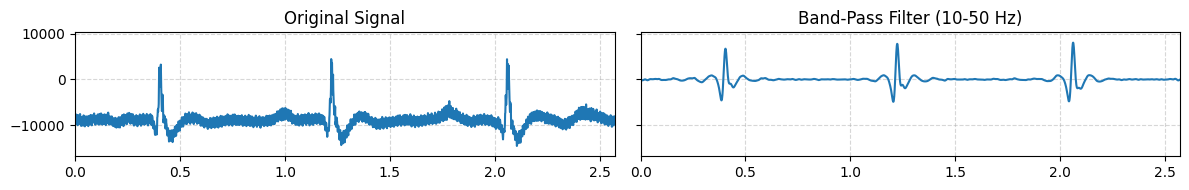

In [22]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt


def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data


# Load sample data from a WAV file
sample_rate, data = scipy.io.wavfile.read('ecg.wav')
times = np.arange(len(data))/sample_rate

dt_ms = 1000.0 / sample_rate
fc_low_Hz = 10.0
fc_high_Hz = 50.0

# Apply a 10-50 Hz high-pass filter to the original data
filtered_sig = bandpass(data, [fc_low_Hz, fc_high_Hz], sample_rate)

# Code used to display the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2), sharex=True, sharey=True)
ax1.plot(times, data)
ax1.set_title("Original Signal")
ax1.margins(0, .1)
ax1.grid(alpha=.5, ls='--')

ax2.plot(times, filtered_sig)
ax2.set_title("Band-Pass Filter (10-50 Hz)")
ax2.grid(alpha=.5, ls='--')

plt.tight_layout()
plt.show()

# Plotting in the z-plane

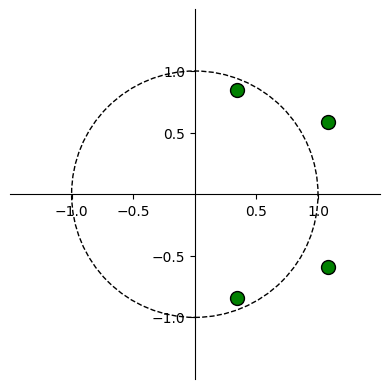

In [11]:
#
# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#

# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.
#
# 2017/03/04 Ryan Robucci - changed plot raduis to expand to 10% beyond largest root real/imag component and and manage ticks

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
    
def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    """

    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    #RWR: the following has been modified to fit larger-magnitude roots and manage ticks
    r = 1.1*max(1.5/1.1,np.abs(np.concatenate((p.real,p.imag,z.real,z.imag))).max()); 
    plt.axis('scaled');
    if r<1.6:
        ticks = [-1, -.5, .5, 1]; 
    elif r<5:
        ticks = [-2,-1, -.5, .5, 1,2]; 
    elif r<10:
        ticks = [-5,-2,-1,1,2,5]; 
    elif r<20:
        ticks = [-10,-1,1,10]; 
    else:
        rlog = np.ceil(np.log10(r))
        ticks = np.arange(-(10**rlog),(10**rlog)+1,10**(rlog-1)*2); 
    
    plt.xticks(ticks);
    plt.yticks(ticks)
    plt.axis([-r, r, -r, r])

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    

    return z, p, k

import numpy as np
#             z^-1 + z^-2 
# H(z)=  --------------------
#          1+.25z^-1-.375z^-2
b = np.array([1,-2.8538,3.8446,-2.8538,1.2656])
a = np.array([1.0])

zplane(b,a)
plt.show()
